# 2D Reaction-Diffusion Problem

This step-by-step tutorial goes over how to use the PRESSIO ROM tools and workflow scripts on the
[2D reaction diffusion PDE problem](https://pressio.github.io/pressio-demoapps/diffusion_reaction_2d.html) from pressio-demoapps.
The full example file is located at [https://github.com/Pressio/rom-tools-and-workflows](https://github.com/Pressio/rom-tools-and-workflows).

Below are the modules required. It is recommended before executing this example that you follow the steps to install [Pressio Demo Apps](https://pressio.github.io/pressio-demoapps/installation.html) and [ROM Tools](https://github.com/Pressio/rom-tools-and-workflows) and ensure you have all necessary modules installed.

In [48]:
%%capture
# Pressio Modules
import pressiodemoapps as pda
import romtools as rt

# Python Modules
import os
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy

Global inputs are defined below.


- `n_x`: Spatial resolution in the x-direction


- `n_y`: Spatial resolution in the y-direction


- `n_snapshots`: Number of FOM training snapshots


- `n_test`: Number of test points/number of ROM predictive runs

In [49]:
# Global inputs
pda_file_path = '../../pressio-demoapps' # path to where pressio demo apps is installed. Necessary for mesh generation.
mesh_path = 'mesh' # path to where mesh is stored
n_x = 50
n_y = 50
n_snapshots = 5
n_test = 20

## Mesh Generation
Below is an example of generating the mesh for a range of x and y resolutions.

The [mesh generation tool](https://pressio.github.io/pressio-demoapps/meshfull.html) to generate the mesh is built into Pressio Demo Apps. The figure below shows the mesh.

diffreac2d


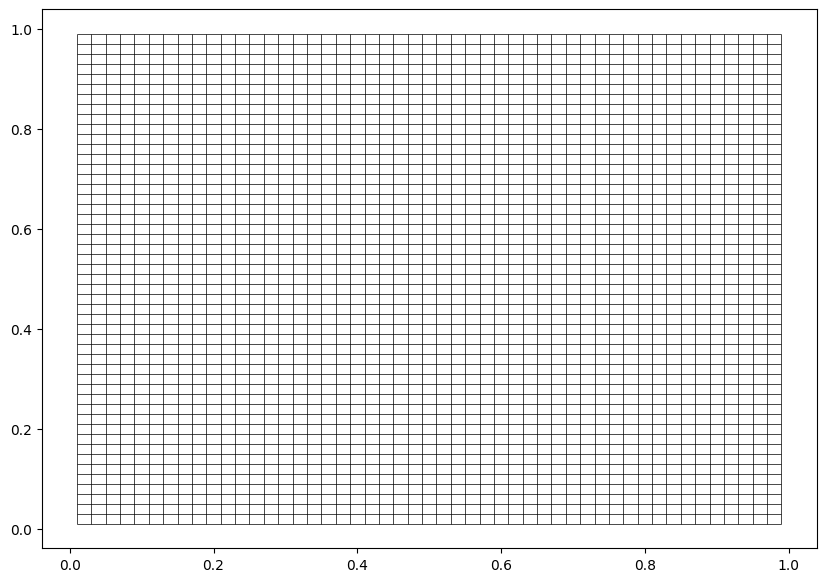

In [50]:
def generate_mesh(pda_file_path, mesh_path, n_x, n_y):
    import os

    # generate mesh
    os.system('python3 ' + pda_file_path + '/meshing_scripts/create_full_mesh_for.py --problem diffreac2d -n ' 
                + str(n_x) + ' ' + str(n_y) + ' --outdir ' + mesh_path)

    # load mesh
    mesh_obj = pda.load_cellcentered_uniform_mesh(mesh_path)

    # plot mesh
    x = mesh_obj.viewX()
    y = mesh_obj.viewY()
    unique_x = list(set(x))
    unique_y = list(set(y))
    ax.cla()
    for i in range(0,len(unique_x)):
        ax.vlines(unique_x[i], np.max(unique_y), np.min(unique_y), colors = 'k', linewidth = 0.5)
    for i in range(0,len(unique_y)):
        ax.hlines(unique_y[i], np.min(unique_x), np.max(unique_x), colors = 'k', linewidth = 0.5)

    return mesh_obj

# Generate and plot mesh
fig = plt.figure(figsize=(10,7))
fig.set_facecolor('w')
ax = plt.gca()
mesh_obj = generate_mesh(pda_file_path=pda_file_path, mesh_path=mesh_path, n_x=n_x, n_y=n_y)
plt.show()

## Full-Order Model
This section will go over how to setup and run the full-order model (FOM). The FOM solves the [2D single-species reaction diffusion problem](https://pressio.github.io/pressio-demoapps/diffusion_reaction_2d.html)

$$
    \frac{\partial \phi}{\partial t} = D \left ( \frac{\partial^{2} \phi}{\partial x^{2}} + \frac{\partial^{2} \phi}{\partial y^{2}} \right ) + k \phi^{2} + u(x,y,t)
$$

where $$u(x,y,t)=4 sin(4 \pi x y) sin(\pi x (y - 2/10)).$$ The source, The source is defined in the Python function `my_source`.


In [63]:
def my_source(x, y, time):
    return 4.*np.sin(4*math.pi*x*y)*np.sin(math.pi*x*(y - 0.2))

To set up the FOM, we follow the `QoiModel` [class](https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/models.html#QoiModel.compute_qoi). This class requires an extra function on top of those required for the `Model` [class](https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/models.html#Model.__init__): `compute_qoi`.

In [52]:
class FOM_Model(rt.workflows.models.QoiModel):
    def __init__(self):
        return None

    def populate_run_directory(self, run_directory, parameter_sample):
        os.system('cp -rp mesh ' + run_directory + '/.')
        return 0

    def run_model(self, run_directory, parameter_sample):
        # Swap to run directory
        cdir = os.getcwd()
        os.chdir(run_directory)

        # Load mesh
        mesh_obj = pda.load_cellcentered_uniform_mesh(mesh_path)

        # Define Scheme
        # A. set scheme
        scheme  = pda.ViscousFluxReconstruction.FirstOrder

        # B. constructor for problem using default values
        prob_ID  = pda.DiffusionReaction2d.ProblemA
        self._problem = pda.create_problem(mesh_obj, prob_ID, scheme)

        # C. setting custom coefficients and custom source function
        self._problem = pda.create_diffusion_reaction_2d_problem_A(mesh_obj, scheme, my_source, parameter_sample['D'], parameter_sample['K'])
        
        # (For Steady ROM)
        # D. Define residual function
        F = self._problem.createRightHandSide()
        def residual(x):
            self._problem.rightHandSide(x,0.,F)
            return F
        
        # Solve FOM
        yn = scipy.optimize.newton_krylov(residual, self._problem.initialCondition(), verbose=False)

        # Save solution
        np.savez('results.npz', y=yn, parameters=[parameter_sample['D'], parameter_sample['K']])

        # Swap back to base directory
        os.chdir(cdir)

        return 0 # NOTE: This function must return 0

    def compute_qoi(self, run_directory, parameter_sample):
        return np.load(run_directory + '/results.npz')['y']

# Define FOM
fom_model = FOM_Model()

## Reduced-Order Model
Here we define our ROM Model class. This class follows the `QoiModelWithErrorEstimate` [class](https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/models.html#QoiModelWithErrorEstimate). This class requires both the `compute_qoi` and `compute_error_estimate` functions on top of those required by the standard `Model` [class](https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/models.html#Model.__init__). This specific model class is required for using greedy sampling for the ROM.

Of note in this model definition is an included check for whether we are using hyperreduction with the ROM, which changes how our sample indices, test basis, and approximation matrix are defined.

In [53]:
class ROM_Model(rt.workflows.models.QoiModelWithErrorEstimate):
    def __init__(self, hyperreduction=False, offline_data_dir=''):
        # Load mesh
        self._mesh_obj = pda.load_cellcentered_uniform_mesh(mesh_path)

        # Load basis
        self._basis = np.load(offline_data_dir + '/basis.npz')['basis']

        # Hyperreduction
        self._hyperreduction = hyperreduction
        if self._hyperreduction:
            self._sample_indices = rt.hyper_reduction.deim_get_indices(self._basis)
            self._test_basis = rt.hyper_reduction.deim_get_test_basis(self._basis, self._basis, self._sample_indices)
            self._approx_mat = rt.hyper_reduction.deim_get_approximation_matrix(self._basis, self._sample_indices)
            np.savez('hyperreduction.npz', sample_indices=self._sample_indices, test_basis=self._test_basis, approx_mat=self._approx_mat)
        else:
            self._sample_indices = range(0,np.shape(self._basis)[0])
            self._test_basis = self._basis
            self._approx_mat = np.eye(np.shape(self._basis)[0])
        return None

    def populate_run_directory(self, run_directory, parameter_sample):
        # NOTE: This is needed when using myRK4
        os.system('ln -s mesh ' + run_directory + '/.')
        return 0

    def run_model(self, run_directory, parameter_sample):
        # Swap to run directory
        cdir = os.getcwd()
        os.chdir(run_directory)

        # Define Scheme
        # A. set scheme
        scheme  = pda.ViscousFluxReconstruction.FirstOrder

        # B. constructor for problem using default values
        prob_ID  = pda.DiffusionReaction2d.ProblemA
        problem = pda.create_problem(self._mesh_obj, prob_ID, scheme)

        # C. setting custom coefficients and custom source function
        problem = pda.create_diffusion_reaction_2d_problem_A(self._mesh_obj, scheme, my_source, parameter_sample['D'], parameter_sample['K'])

        # Run ROM
        # A. get initial condition
        yn = problem.initialCondition()
        qn = np.matmul(self._test_basis.transpose(), yn[self._sample_indices])

        # B. solve ROM
        rom = ROM(basis=self._basis, problem=problem, hyperreduction=self._hyperreduction, sample_indices=self._sample_indices, test_basis=self._test_basis, approx_mat=self._approx_mat)

        # D. Define residual function
        F = rom.createRightHandSide()
        def residual(x):
            _, v = rom.rightHandSide(np.matmul(self._test_basis, x),0.,np.matmul(self._test_basis, F))
            return v

        # Solve FOM
        qn = scipy.optimize.newton_krylov(residual, np.matmul(self._test_basis.transpose(), problem.initialCondition()[self._sample_indices]), verbose=False, f_tol=1e-8)

        # Reconstruct solution
        yn = np.matmul(self._test_basis, qn)

        # Compute inverse of diagonal of Jacobian
        J = problem.createApplyJacobianResult(np.eye(np.shape(yn)[0]))
        problem.applyJacobian(yn, np.eye(np.shape(yn)[0]), 0., J)
        invJ = np.zeros(np.shape(J))
        count = 0
        for x in np.diag(J):
            invJ[count,count] = 1./x
            count += 1

        # Save results
        print(run_directory)
        np.savez('results.npz', y=yn, parameters=[parameter_sample['D'], parameter_sample['K']], res=np.matmul(self._test_basis,residual(qn)), invJ=invJ)

        # Swap back to base directory
        os.chdir(cdir)

        return 0 # NOTE: This function must return 0

    def compute_qoi(self, run_directory, parameter_sample):
        # Load from npz file and return y
        return np.load(run_directory + '/results.npz')['y']

    def compute_error_estimate(self, run_directory, parameter_sample):
        # Run model
        y = self.run_model(run_directory, parameter_sample)

        # Read in results
        dat = np.load(run_directory + '/results.npz')
        invJ = dat['invJ']
        res = dat['res']

        # Calculate error estimate
        return np.linalg.norm(np.matmul(invJ,res))

A separate ROM class was created for interfacing to Pressio Demo Apps. This class definition below would not be required if the user is not using Pressio Demo Apps.

In [54]:
class ROM():
    def __init__(self, basis, problem, hyperreduction, sample_indices, test_basis, approx_mat):
        self._basis = basis
        self._problem = problem
        self._hyperreduction = hyperreduction
        self._sample_indices = sample_indices
        self._test_basis = test_basis
        self._approx_mat = approx_mat
    
    def initializeRightHandSide(self):
        self._problem.createRightHandSide()
    
    def createRightHandSide(self):
        self._problem.createRightHandSide()
        return np.zeros(self._test_basis.shape[1])

    def rightHandSide(self, state, time, v):
        if self._hyperreduction == True:
            # NOTE: v is overwritten on call to rightHandSide
            v = np.matmul(self._approx_mat, v)
            self._problem.rightHandSide(state, time, v)
            state = np.matmul(self._test_basis.transpose(), state[self._sample_indices])
            v = np.matmul(self._test_basis.transpose(), v[self._sample_indices])
        else:
            self._problem.rightHandSide(state, time, v)
            state = np.matmul(self._test_basis.transpose(), state)
            v = np.matmul(self._test_basis.transpose(), v)

        return state, v

## Defining the Parameter Space
The final step is defining the parameter space, which is done by filling in the functions for the `ParameterSpace` [class](https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/parameter_spaces.html).

The sampling for the parameters is done using the [Monte Carlo Sampler](https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/sampling_methods.html#MonteCarloSampler) available through ROM Tools.

In [55]:
class ParameterSpace():
    def __init__(self, parameter_name, num_parameters, bounds):
        self._parameter_name = parameter_name
        self._dimension = num_parameters
        self._bounds = np.array(bounds)

    def get_names(self):
        return self._parameter_name
    
    def get_dimensionality(self):
        return self._dimension
    
    def get_sampler(self):
        return rt.workflows.sampling_methods.MonteCarloSampler

    def generate_samples(self, n_samples):
        # Grab sampler
        sampler = self.get_sampler()

        # Generate samples
        samples = sampler(number_of_samples=n_samples, dimensionality=self._dimension, seed=None)

        # Scale to bounds
        scale =  self._bounds[:,1::] - self._bounds[:,0:1]
        samples = samples*scale.transpose() + self._bounds[:,0:1].transpose()
        
        return np.array(samples)

# Define parameter space
param_space = ParameterSpace(parameter_name=['K', 'D'], num_parameters=2, bounds=[[0.005, 0.015], [0.005, 0.015]])

## Plotting Functions
These are not necessary for creating the FOM or ROM, but are used for visualization purposes only. If you would like to add gridlines to the figures, set `with_grid=True` on call to the functions.

In [56]:

def plot_single_result(mesh_obj, yn, K_label, D_label, with_grid):
    x = mesh_obj.viewX()
    y = mesh_obj.viewY()
    unique_x = list(set(x))
    unique_y = list(set(y))
    plt.figure(figsize=(10,7))
    if with_grid:
        for i in range(0,len(unique_x)):
            plt.vlines(unique_x[i], np.max(unique_y), np.min(unique_y), colors = 'k', linewidth = 0.5, alpha=0.2)
        for i in range(0,len(unique_y)):
            plt.hlines(unique_y[i], np.min(unique_x), np.max(unique_x), colors = 'k', linewidth = 0.5, alpha=0.2)
    plt.tricontourf(x, y, yn, cmap='coolwarm')
    plt.colorbar()
    plt.title(K_label + ', ' + D_label)
    plt.show()

def plot_results(mesh_obj, y_fom, y_rom, K_label, D_label, with_grid):
    x = mesh_obj.viewX()
    y = mesh_obj.viewY()
    unique_x = list(set(x))
    unique_y = list(set(y))
    vmin_ = np.min(y_fom)
    vmax_ = np.max(y_fom)
    
    fig, ax = plt.subplots(2,1,figsize=(9,12))
    plt.sca(ax[0])
    if with_grid:
        for i in range(0,len(unique_x)):
            plt.vlines(unique_x[i], np.max(unique_y), np.min(unique_y), colors = 'k', linewidth = 0.5, alpha=0.2)
        for i in range(0,len(unique_y)):
            plt.hlines(unique_y[i], np.min(unique_x), np.max(unique_x), colors = 'k', linewidth = 0.5, alpha=0.2)
    im = plt.tricontourf(x, y, y_fom, cmap='coolwarm', vmin=vmin_, vmax=vmax_)
    plt.sca(ax[1])
    if with_grid:
        for i in range(0,len(unique_x)):
            plt.vlines(unique_x[i], np.max(unique_y), np.min(unique_y), colors = 'k', linewidth = 0.5, alpha=0.2)
        for i in range(0,len(unique_y)):
            plt.hlines(unique_y[i], np.min(unique_x), np.max(unique_x), colors = 'k', linewidth = 0.5, alpha=0.2)
    im = plt.tricontourf(x, y, y_rom, cmap='coolwarm', vmin=vmin_, vmax=vmax_)
    fig.colorbar(im, ax=ax.ravel().tolist())
    plt.title(K_label + ', ' + D_label)
    plt.show()


## Example: Monte Carlo Sampling of FOM
Below is an example of sampling the FOM using Monte Carlo sampling. The sampling is done twice for a training set and for a test set and are stored in directories labeled "train" and "test", respectively.

In [57]:
%%capture
# A. Run FOM at train/test points using montecarlo sampling
rt.workflows.sampling.run_sampling(model=fom_model, parameter_space=param_space, run_directory_prefix='train/fom_', number_of_samples=n_snapshots, random_seed=1)
rt.workflows.sampling.run_sampling(model=fom_model, parameter_space=param_space, run_directory_prefix='test/fom_', number_of_samples=n_test, random_seed=2)

# B. Read in train/test snapshots (NOTE: snapshots should be a tensor)
n_vars = 1 # number of PDE variables
n = n_x * n_y # number of spatial DOFs
snapshots_train = np.zeros((n_vars, n, n_snapshots))
parameters_train = np.zeros((n_snapshots, 2))
for i in range(0,n_snapshots):
    results = np.load('train/fom_' + str(i) + '/results.npz')
    snapshots_train[:,:,i] = results['y']
    parameters_train[i,:] = results['parameters']
snapshots_test = np.zeros((n_vars, n, n_test))
parameters_test = np.zeros((n_test, 2))
for i in range(0,n_test):
    results = np.load('test/fom_' + str(i) + '/results.npz')
    snapshots_test[:,:,i] = results['y']
    parameters_test[i,:] = results['parameters']


Here we plot a contour of $\phi$ at a training point where $K=0.012$ and $D=0.009$.

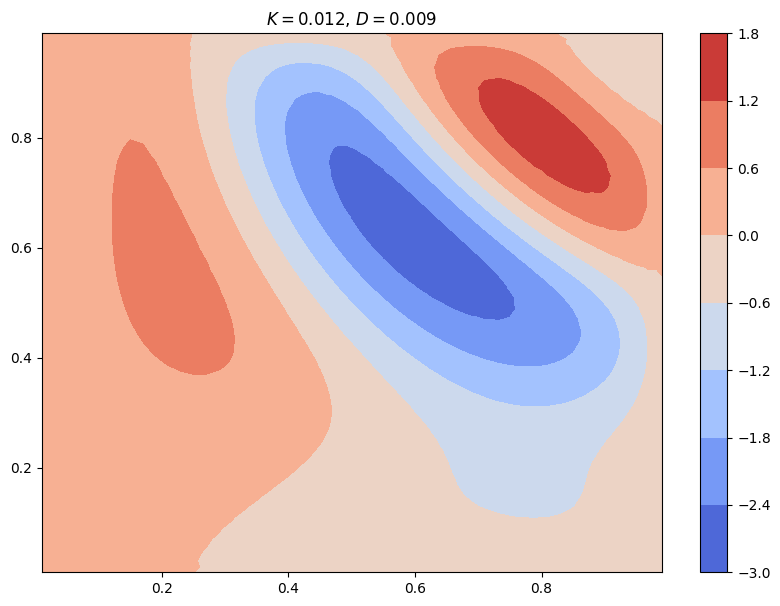

In [58]:
# C. Plot results for one snapshot
plot_single_result(mesh_obj, snapshots_train[0,:,0], K_label=f'$K={parameters_train[0,0]:.3f}$', D_label=f'$D={parameters_train[0,1]:.3f}$', with_grid=False)

## Creating the POD Basis

This section shows an example of how to create the POD basis. There are multiple options available through ROM Tools for creating the basis and can be explored [here](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space/utils.html).

In this example, we create a [POD](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space.html#VectorSpaceFromPOD) `VectorSpace` with no [truncation](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space/utils/truncater.html#NoOpTruncater) and use an [Euclidean L2 inner product](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space/utils/orthogonalizer.html#EuclideanL2Orthogonalizer). 

The `shifter` and `scaler` options for creating a `VectorSpace` are set to their default options when not defined. Since `truncater` is set to its default option below, it is not necessary to define it explicitly in the code but is given as an example.

As reference, The first POD mode is plotted below.

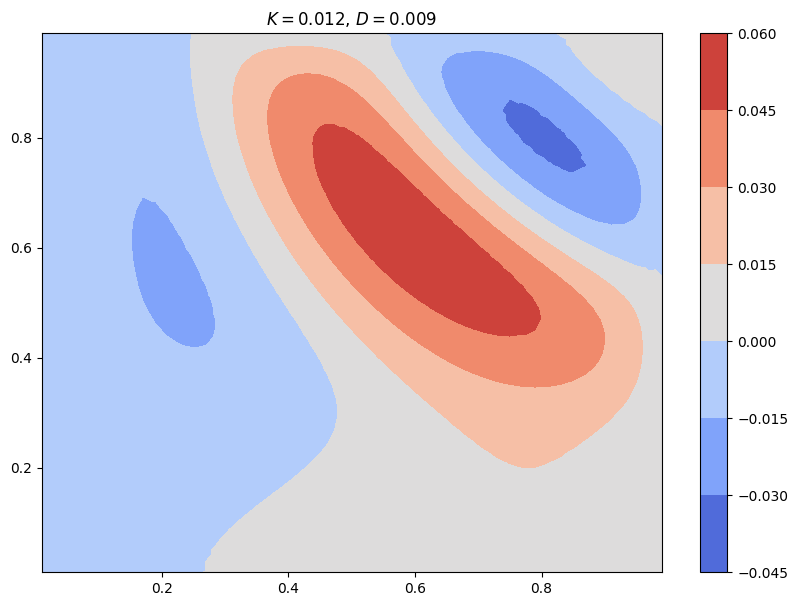

In [59]:
truncater = rt.vector_space.utils.truncater.NoOpTruncater()
orthogonalizer = rt.vector_space.utils.orthogonalizer.EuclideanL2Orthogonalizer()
pod_space = rt.vector_space.VectorSpaceFromPOD(snapshots=snapshots_train, truncater=truncater, orthogonalizer=orthogonalizer)
basis = pod_space.get_basis()[0]
np.savez('basis.npz',basis=basis) # NOTE: This is read in by run_model

# Plot zeroth mode
plot_single_result(mesh_obj, basis[:,0], K_label=f'$K={parameters_train[0,0]:.3f}$', D_label=f'$D={parameters_train[0,1]:.3f}$', with_grid=False)

## Example: ROM trained on FOM snapshots using MC Sampling

In this section we demonstrate running the ROM trained by the FOM snapshots using MC Sampling. The ROM is used to predict at test points in the parameter domain, *i.e.*, at points it was not trained on.


In [60]:
%%capture
# A. Define ROM Model
rom_model = ROM_Model(hyperreduction=False, offline_data_dir=os.getcwd())

# B. Run ROM at test points
# NOTE: As long as the same seed is chosen, the ROM will run at the same points as the FOM.
os.system('rm -rf test/rom_*')
rt.workflows.sampling.run_sampling(model=rom_model, parameter_space=param_space, run_directory_prefix='test/rom_', number_of_samples=n_test, random_seed=2)

# C. Read in ROM results
rom_snapshots_test = np.zeros((n_vars, n, n_test))
rom_parameters_test = np.zeros((n_test, 2))
for i in range(0,n_test):
    results = np.load('test/rom_' + str(i) + '/results.npz')
    rom_snapshots_test[:,:,i] = results['y']
    rom_parameters_test[i,:] = results['parameters']

We plot a comparison between the ROM and the FOM at one test point. The ROM very closely matches the FOM.

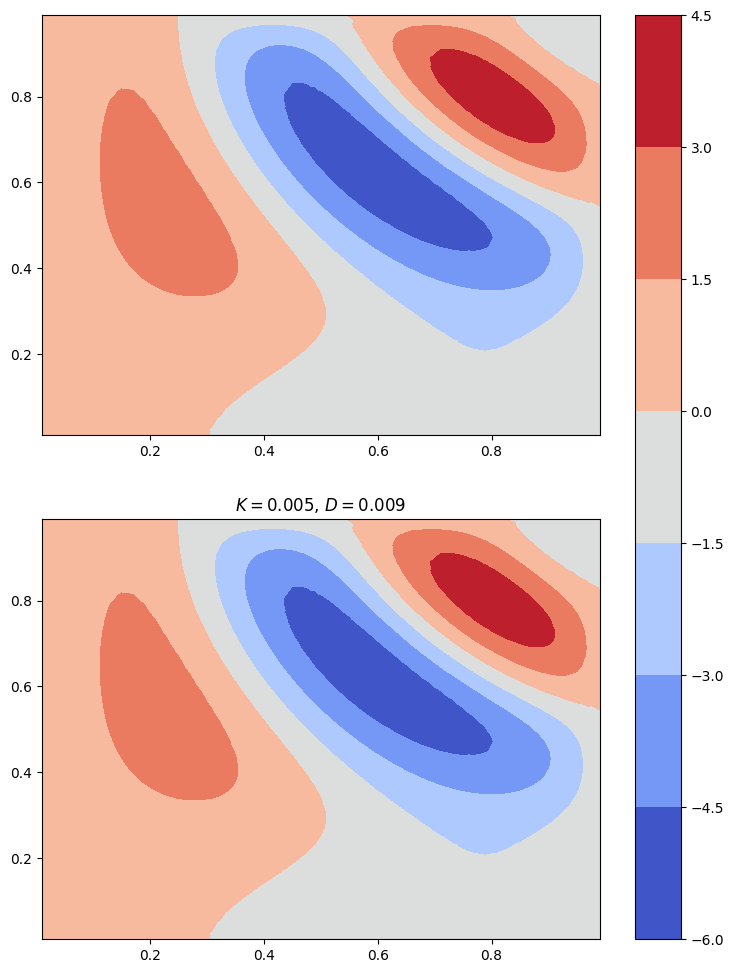

In [61]:
# F. Plot ROM/FOM results at one test point
plot_results(mesh_obj, snapshots_test[0,:,0], rom_snapshots_test[0,:,0], K_label=f'$K={parameters_test[0,0]:.3f}$', D_label=f'$D={parameters_test[0,1]:.3f}$', with_grid=False)

The L2 norm of the error between the ROM and the FOM across all test points is calculated here. The ROM predicts accurately across all test points.

In [62]:
# G. Calculate error
print('L2 Norm of Error between ROM and FOM at test points using MC sampling: ', np.linalg.norm(snapshots_test - rom_snapshots_test), '\n')

L2 Norm of Error between ROM and FOM at test points using MC sampling:  0.006844890423384241 

